In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
%run scripts/helper.py

In [3]:
crowd_train = load_file('./data/train.csv/train.csv', index_col='id')
crowd_test = load_file('./data/test.csv/test.csv', index_col='id')

In [4]:
traindata = prepareText(crowd_train)
testdata = prepareText(crowd_test)

In [77]:
y = getTargetVariable(crowd_train)

In [6]:
from sklearn.metrics import make_scorer

# Weighted kappa scorer
kappa_scorer = make_scorer(quadratic_weighted_kappa, greater_is_better=True)

In [7]:
# columns
crowd_train.columns

Index([u'query', u'product_title', u'product_description', u'median_relevance', u'relevance_variance'], dtype='object')

In [8]:
# class distibution
crowd_train.median_relevance.value_counts()

4    6171
3    1737
2    1476
1     774
dtype: int64

In [9]:
crowd_train.groupby('median_relevance').describe()

relevance_variance
median_relevance                          
1                count          774.000000
                 mean             0.382893
                 std              0.437872
                 min              0.000000
                 25%              0.000000
                 50%              0.471000
                 75%              0.471000
                 max              1.414000
2                count         1476.000000
                 mean             0.618362
                 std              0.335397
                 min              0.000000
                 25%              0.471000
                 50%              0.471000
                 75%              0.943000
                 max              1.356000
3                count         1737.000000
                 mean             0.619174
                 std              0.299838
                 min              0.000000
                 25%              0.471000
                 50%              0.471000
                 75%              0.894000
                 max              1.374000
4                count         6171.000000
                 mean             0.251786
                 std              0.357309
                 min              0.000000
                 25%              0.000000
                 50%              0.000000
                 75%              0.471000
                 max              1.470000

In [10]:
crowd_train['length'] = crowd_train.apply(lambda x: len(x['product_title']) + len(x['product_description']), axis=1)

In [11]:
crowd_train.head()

,query,product_title,product_description,median_relevance,relevance_variance,length
id,,,,,,
1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000,117
2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000,976
4,projector,ViewSonic Pro8200 DLP Multimedia Projector,,4,0.471,42
5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000,783
7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471,361


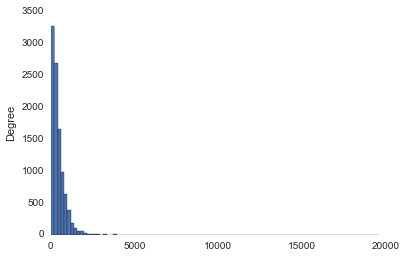

In [13]:
crowd_train.length.plot(bins=100, kind='hist');

In [14]:
crowd_train.length.describe()

count    10158.000000
mean       447.585942
std        591.602290
min          8.000000
25%        100.000000
50%        319.000000
75%        596.000000
max      19615.000000
Name: length, dtype: float64

### Is there any difference in message length among different classes

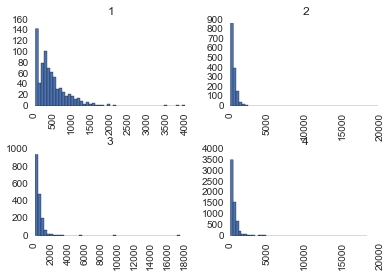

In [15]:
crowd_train.hist(column='length', by='median_relevance', bins=50);

### Since there is lot of junk in product description lets omit this for now

In [16]:
crowd_train['length'] = crowd_train.product_title.map(lambda text: len(text))

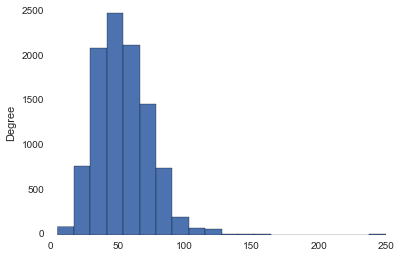

In [17]:
crowd_train.length.plot(bins=20, kind='hist');

In [18]:
crowd_train.length.describe()

count    10158.000000
mean        53.996358
std         20.262103
min          5.000000
25%         40.000000
50%         52.000000
75%         67.000000
max        250.000000
Name: length, dtype: float64

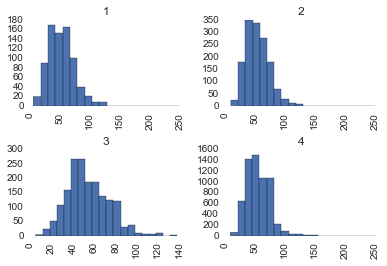

In [19]:
# lets look at length distribution among differnt classes
crowd_train.hist(column='length', by='median_relevance', bins=20);

### Preprocessing

In [21]:
# some examples of product title
crowd_train.product_title.head()

id
1           Accent Pillow with Heart Design - Red/Black
2     Set of 10 Battery Operated Multi LED Train Chr...
4            ViewSonic Pro8200 DLP Multimedia Projector
5     Concept Housewares WR-44526 Solid-Wood Ceiling...
7     Wintergreen Lighting Christmas LED Light Bulb ...
Name: product_title, dtype: object

In [27]:
# some examples of product description
crowd_train.product_description.head()

id
1     Red satin accent pillow embroidered with a hea...
2     Set of 10 Battery Operated Train Christmas Lig...
4                                                      
5     Like a silent and sturdy tree, the Southern En...
7     WTGR1011\nFeatures\nNickel base, 60,000 averag...
Name: product_description, dtype: object

### Tokenizing

In [21]:
from nltk.tokenize import TreebankWordTokenizer

In [24]:
sample = traindata[:5]
TreebankWordTokenizer().tokenize(sample[0])

['bridal',
 'shower',
 'decorations',
 'Accent',
 'Pillow',
 'with',
 'Heart',
 'Design',
 '-',
 'Red/Black',
 'Red',
 'satin',
 'accent',
 'pillow',
 'embroidered',
 'with',
 'a',
 'heart',
 'in',
 'black',
 'thread.',
 '8',
 "''",
 'x',
 '8',
 "''",
 '.']

In [25]:
# convert data into vectors
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
bow_transformer = CountVectorizer(analyzer='word', tokenizer=TreebankWordTokenizer().tokenize).fit(sample)

In [30]:
messages_bow = bow_transformer.transform(sample)
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

sparse matrix shape: (5, 258)
number of non-zeros: 298
sparsity: 23.10%


In [34]:
# tf idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [35]:
tfidf4 = tfidf_transformer.transform(messages_bow)

In [36]:
print tfidf4.shape

(5, 258)


### Training a model : Predicting Search Query Relevance

In [160]:
g = crowd_train.groupby('median_relevance')

In [161]:
train_data_y_1 = prepareText(g.get_group(1))
y_1 = g.get_group(1).median_relevance.values

In [162]:
train_data_y_2 = prepareText(g.get_group(2))
y_2 = g.get_group(2).median_relevance.values

In [163]:
train_data_y_3 = prepareText(g.get_group(3))
y_3 = g.get_group(3).median_relevance.values

In [164]:
train_data_y_4 = prepareText(g.get_group(4))
y_4 = g.get_group(4).median_relevance.values

In [165]:
train_data_y_1 = train_data_y_1[:774]
y_1 = y_1[:774]

train_data_y_2 = train_data_y_2[:774]
y_2 = y_2[:774]

train_data_y_3 = train_data_y_3[:774]
y_3 = y_3[:774]

train_data_y_4 = train_data_y_4[:774]
y_4 = y_4[:774]

In [166]:
training_data = np.hstack([train_data_y_1, train_data_y_2, train_data_y_3, train_data_y_4])
y_train = np.hstack([y_1, y_2, y_3, y_4])

In [167]:
pd.Series(y_train).value_counts()

3    774
1    774
4    774
2    774
dtype: int64

In [232]:
train_index = np.arange(0, training_data.shape[0])
np.random.shuffle(train_index)

In [234]:
training_data = training_data[train_index]
y_train = y_train[train_index]

In [235]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [249]:
pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=3, max_features=None, 
            strip_accents='unicode', analyzer='char',
            ngram_range=(1, 4), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')),
        ('svd', TruncatedSVD(n_components=400)),
        ('scl', StandardScaler()),
        ('classifier', SVC(C=10.0))
    ])

In [250]:
from sklearn.cross_validation import cross_val_score

In [248]:
scores = cross_val_score(pipeline, training_data.astype(str), 
                         y_train, cv=2, scoring=kappa_scorer,
                         n_jobs=1)

print scores

MemoryError: 

In [239]:
Xt = training_data[:-800]
yt = y_train[:-800]

Xv = training_data[-800:]
yv = y_train[-800:]

In [240]:
# fit the model on the whole dataset
pipeline.fit(Xt, yt)

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 5), norm=u'l2', preprocessor=None, smooth_idf=1,
 ...     vocabulary=None)), ('classifier', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

In [243]:
nb_predict = pipeline.predict(Xv)

In [241]:
pipeline1 = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=3, max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 5), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')),
        ('svd', TruncatedSVD(n_components=400)),
        ('scl', StandardScaler()),
        ('classifier', SVC(C=10.0))
    ])

In [242]:
pipeline1.fit(Xt, yt)

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 5), norm=u'l2', preprocessor=None, smooth_idf=1,
 ...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [244]:
svc_predict = pipeline1.predict(Xv)

In [245]:
print 'How un-correlated these models are %0.5f ' %(how_uncorrelated(yv, nb_predict, svc_predict))

How un-correlated these models are 11.87500 
